# A notebook to find the lowest energy conformer of a TS

This notebook will be similar to the `molecule_torsion` notebook but will require more setup to get the a rough TS geometry.

The step we plan to do are as follows:

1) Create a reasonable TS geometry using the existing framework provided in AutoTST

2) Add pseudo bonds the `reactants` molecule where the `1*`, `2*`, and `3*` atoms are

3) Identify all possible torsions

4) Run through all the possible conformers and calculate the lowest energy conformer from RDKit

For step for, we will do a systematic operation of adding the pseudo bonds to the molecule, setting the torsions, deleting the pseudo bonds, and calculating the energy. This will be done for each conformer and _ideally_ the lowest energy conformer would be further optimized using a quantum package

#### NOTE: We may also need to look at the angle created by `1*`, `2*`, and `3*` ~ This will be studied once the torsional part is up and running

In [1]:
import os
import sys
import cPickle as pkl
import logging
FORMAT = "%(filename)s:%(lineno)d %(funcName)s %(levelname)s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

import re
import imp
import itertools
import random
import numpy as np
from numpy import array
import pandas as pd
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns


# do this before we have a chance to import openbabel!
import rdkit, rdkit.Chem.rdDistGeom, rdkit.DistanceGeometry

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from rdkit.Chem.rdMolTransforms import *

import py3Dmol

from rmgpy.molecule import Molecule
from rmgpy.species import Species
from rmgpy.reaction import Reaction
from rmgpy.kinetics import PDepArrhenius, PDepKineticsModel

from rmgpy.data.rmg import RMGDatabase
from rmgpy.data.kinetics import KineticsDepository, KineticsRules
from rmgpy.qm.main import QMCalculator, QMSettings
from rmgpy.qm.qmdata import QMData
from rmgpy.qm.reaction import QMReaction
from rmgpy.qm.molecule import QMMolecule


/Users/nathan/anaconda/envs/rmg_env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
rxnFamily = ['H_Abstraction']
print('Loading RMG Database ...')
rmgDatabase = RMGDatabase()
databasePath = os.path.abspath(os.path.join(os.getenv('RMGpy', '..'), '..', 'RMG-database', 'input'))
print(databasePath)
rmgDatabase.load(databasePath,
                 kineticsFamilies=rxnFamily,
                 transportLibraries=[],
                 reactionLibraries=[],
                 seedMechanisms=[],
                 thermoLibraries=['primaryThermoLibrary', 'KlippensteinH2O2', 'thermo_DFT_CCSDTF12_BAC', 'CBS_QB3_1dHR' ],
                 solvation=False,
                 )
print('RMG Database Loaded')


## We are using a ts Pickle from discovery. 
## I was running into issues performing ts opts locally, so this is a workaround
f = open("../tsDatabase.pkl", "r")
tsDatabase = pkl.load(f)

settings = QMSettings(
    software='gaussian',
    method='m062x',
    fileStore=os.path.expandvars('.'),
    scratchDirectory=os.path.expandvars('.'),
    )

thermo.py:760 loadLibraries INFO Loading thermodynamics library from CBS_QB3_1dHR.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from KlippensteinH2O2.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from primaryThermoLibrary.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:760 loadLibraries INFO Loading thermodynamics library from thermo_DFT_CCSDTF12_BAC.py in /Users/nathan/Code/RMG-database/input/thermo/libraries...
thermo.py:774 loadGroups INFO Loading thermodynamics group database from /Users/nathan/Code/RMG-database/input/thermo/groups...


Loading RMG Database ...
/Users/nathan/Code/RMG-database/input


transport.py:294 loadGroups INFO Loading transport group database from /Users/nathan/Code/RMG-database/input/transport/groups...
database.py:165 loadFamilies INFO Loading the user-specified kinetics families from /Users/nathan/Code/RMG-database/input/kinetics/families
statmech.py:526 loadGroups INFO Loading frequencies group database from /Users/nathan/Code/RMG-database/input/statmech/groups...


RMG Database Loaded


In [3]:
def view_mol(mol):
    """
    A function designed to visulaize rdkit molecules
    
    Input: mol (an rdkit molecule object)
    
    Output: 3D figure of the molecule from py3Dmol
    
    """
    mb  = Chem.MolToMolBlock(mol)
    p = py3Dmol.view(width=400, height=400)
    p.addModel(mb, "sdf")
    p.setStyle({'stick':{}})
    p.setBackgroundColor('0xeeeeee')
    p.zoomTo()
    return p.show()

In [4]:
def calc_energy(mol):
    """
    A function designed to calculate the energy of a molecule or TS
    
    Input: rdkit molecule object
    
    Output: energy of the geometry calculated using rdkit's forcefield method
    """
    try:
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(mol)
    except:
    
        # Picking an arbitrarly large molecule to create a dummy mol properties forcefield object
        test_mol = Chem.AddHs(Chem.MolFromSmiles(
            "COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO"
        ))
        
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(test_mol)
    ff = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeForceField(mol, molprop)
    return ff.CalcEnergy()

## Creating a reaction to test

In [5]:
rSpecies1 = Molecule(SMILES="CCCCCC")
rSpecies2 = Molecule(SMILES="[O]O")
pSpecies2 = Molecule(SMILES="[CH2]CCCCC")
pSpecies1 = Molecule(SMILES="OO")


oohReaction = Reaction(reactants=[rSpecies1, rSpecies2], products=[pSpecies1, pSpecies2], reversible=True)
oohReaction

In [6]:
rxnFamily = "H_Abstraction"
rSpecies1, rSpecies2 = oohReaction.reactants
pSpecies1, pSpecies2 = oohReaction.products

rSpecies1.generateResonanceIsomers()
rSpecies2.generateResonanceIsomers()
pSpecies1.generateResonanceIsomers()
pSpecies2.generateResonanceIsomers()

testReaction = Reaction(reactants=[rSpecies1, rSpecies2], products=[pSpecies1, pSpecies2], reversible=True)
reactionList = []
"""for moleculeA in rSpecies1.molecule:
    for moleculeB in rSpecies2.molecule:"""
tempList = rmgDatabase.kinetics.generateReactionsFromFamilies([rSpecies1, rSpecies2], [], only_families=[rxnFamily])
for rxn0 in tempList:
    reactionList.append(rxn0)
logging.info("generateReactionsFromFamilies successfuly performed")
print reactionList


<ipython-input-6-ade7a37b092a>:17 <module> INFO generateReactionsFromFamilies successfuly performed


[Reaction(reactants=[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[O]O")], products=[Molecule(SMILES="OO"), Molecule(SMILES="CC[CH]CCC")], degeneracy=4, pairs=[[Molecule(SMILES="CCCCCC"), Molecule(SMILES="CC[CH]CCC")], [Molecule(SMILES="[O]O"), Molecule(SMILES="OO")]]), Reaction(reactants=[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[O]O")], products=[Molecule(SMILES="OO"), Molecule(SMILES="C[CH]CCCC")], degeneracy=4, pairs=[[Molecule(SMILES="CCCCCC"), Molecule(SMILES="C[CH]CCCC")], [Molecule(SMILES="[O]O"), Molecule(SMILES="OO")]]), Reaction(reactants=[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[O]O")], products=[Molecule(SMILES="OO"), Molecule(SMILES="[CH2]CCCCC")], degeneracy=6, pairs=[[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[CH2]CCCCC")], [Molecule(SMILES="[O]O"), Molecule(SMILES="OO")]])]


## Labeling the atoms in the reaction

In [7]:

gotOne=False
for reaction in reactionList:
    # Check if any of the RMG proposed reactions matches the reaction in the mechanism
    if testReaction.isIsomorphic(reaction):
        print "Found matching reaction"
        # Now add the labeled atoms to the Molecule, and check all labels were added
        atLblsR = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])
        atLblsP = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])

        for reactant in reaction.reactants:

            reactant.clearLabeledAtoms()
            for atom in reactant.atoms:
                for atomLabel in reaction.labeledAtoms:
                    if atom==atomLabel[1]:
                        atom.label = atomLabel[0]
                        atLblsR[atomLabel[0]] = True
        for product in reaction.products:

            product.clearLabeledAtoms()
            for atom in product.atoms:
                for atomLabel in reaction.labeledAtoms:
                    if atom==atomLabel[1]:
                        atom.label = atomLabel[0]
                        atLblsP[atomLabel[0]] = True
        if all( atLblsR.values() ) and all( atLblsP.values() ):
            gotOne=True
            break
rxn = testReaction
rxn

Found matching reaction


## Ripping this from the AutoTST submit scripts... There is def some redundance from above, but I'm not sure what exactly

In [8]:

def performCalcs(chemkinRxn):
    rxnFamily = "H_Abstraction"
    rxnFamilies = ['H_Abstraction']
    logging.info("chemkinRxn: {!r}".format(chemkinRxn))
    # Ensure all resonance isomers have been generated
    logging.info('Ensuring resonance isomers have been generated')
    for species in itertools.chain(chemkinRxn.reactants, chemkinRxn.products):
        print(type(species))
        species = species.generateResonanceIsomers()

    testReaction = Reaction(reactants=chemkinRxn.reactants, products=chemkinRxn.products, reversible=True)

    reactants = [species for species in chemkinRxn.reactants]
    # reactant_molecules is a list of lists of resonance isomers,
    # eg. a bimolecular reaction where the second reactant has 2 isomers is: [[r1],[r2i1,r2i2]]

    products = [species for species in chemkinRxn.products]
    # products is a list of molecule objects (only one resonance form of each product), eg [p1, p2]
    print reactants
    #print type(reactant_molecules[0])
    print products

    checkRxn = rmgDatabase.kinetics.generateReactionsFromFamilies(reactants, products, only_families=rxnFamilies)# reversible=True)
    if len(checkRxn) == 1:
        logging.info("Generated one reaction:")
        logging.info(checkRxn)
        reaction = checkRxn[0]
    else:  # didn't break from for loop
        for reaction in checkRxn:
            logging.info("Generated these reactions:")
            logging.info(reaction)
            reaction = checkRxn[0]
        raise Exception("Couldn't generate exactly one reaction matching {} in family {}".format(chemkinRxn, rxnFamilies))

    logging.info("The reaction of interest is as follows: ")
    logging.info(reaction)

    logging.info("asserting that the testReaction is Isomorphic")
    assert testReaction.isIsomorphic(reaction)
    logging.info("reaction: {!r}".format(reaction))

    atLblsR = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])
    atLblsP = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])

    gotOne = False
    logging.info("Labeling reactant atoms")
    for reactant in reaction.reactants:
        reactant = reactant
        reactant.clearLabeledAtoms()
        for atom in reactant.atoms:
            for atomLabel in reaction.labeledAtoms:
                if atom == atomLabel[1]:
                    atom.label = atomLabel[0]
                    atLblsR[atomLabel[0]] = True

    logging.info("Labeling product atoms")
    for product in reaction.products:
        product = product
        product.clearLabeledAtoms()
        for atom in product.atoms:
            for atomLabel in reaction.labeledAtoms:
                if atom == atomLabel[1]:
                    atom.label = atomLabel[0]
                    atLblsP[atomLabel[0]] = True

    if all(atLblsR.values()) and all(atLblsP.values()):
        gotOne = True

    rxnFamily = reaction.family
    return reaction

rxn = performCalcs(rxn)
rxn = QMReaction(reaction=rxn, settings=settings, tsDatabase=tsDatabase)
rxn

<ipython-input-8-2740c8bb36db>:5 performCalcs INFO chemkinRxn: Reaction(reactants=[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[O]O")], products=[Molecule(SMILES="OO"), Molecule(SMILES="[CH2]CCCCC")])
<ipython-input-8-2740c8bb36db>:7 performCalcs INFO Ensuring resonance isomers have been generated
<ipython-input-8-2740c8bb36db>:26 performCalcs INFO Generated one reaction:
<ipython-input-8-2740c8bb36db>:27 performCalcs INFO [Reaction(reactants=[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[O]O")], products=[Molecule(SMILES="OO"), Molecule(SMILES="[CH2]CCCCC")], degeneracy=6, pairs=[[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[CH2]CCCCC")], [Molecule(SMILES="[O]O"), Molecule(SMILES="OO")]])]


<type 'rmgpy.molecule.molecule.Molecule'>
<type 'rmgpy.molecule.molecule.Molecule'>
<type 'rmgpy.molecule.molecule.Molecule'>
<type 'rmgpy.molecule.molecule.Molecule'>
[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[O]O")]
[Molecule(SMILES="OO"), Molecule(SMILES="[CH2]CCCCC")]


<ipython-input-8-2740c8bb36db>:36 performCalcs INFO The reaction of interest is as follows: 
<ipython-input-8-2740c8bb36db>:37 performCalcs INFO <Molecule "CCCCCC"> + <Molecule "[O]O"> <=> <Molecule "OO"> + <Molecule "[CH2]CCCCC">
<ipython-input-8-2740c8bb36db>:39 performCalcs INFO asserting that the testReaction is Isomorphic
<ipython-input-8-2740c8bb36db>:41 performCalcs INFO reaction: Reaction(reactants=[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[O]O")], products=[Molecule(SMILES="OO"), Molecule(SMILES="[CH2]CCCCC")], degeneracy=6, pairs=[[Molecule(SMILES="CCCCCC"), Molecule(SMILES="[CH2]CCCCC")], [Molecule(SMILES="[O]O"), Molecule(SMILES="OO")]])
<ipython-input-8-2740c8bb36db>:47 performCalcs INFO Labeling reactant atoms
<ipython-input-8-2740c8bb36db>:57 performCalcs INFO Labeling product atoms


<rmgpy.qm.reaction.QMReaction instance at 0x114cdfea8>

## Making a single RDKit molecule from the RMG QM reaction

In [9]:

reactant, product = rxn.setupMolecules()
mol = reactant.toRDKitMol(removeHs=False)
AllChem.EmbedMolecule(mol)
view_mol(mol)

## Creating a reasionable goemetry

#### For some reason, the following cell won't successfully complete unless you run it twice... There's a bug here but I'll address it later

In [10]:


labels, atomMatch = rxn.getLabels(reactant)

tsRDMol, bm, rxn.reactantGeom = rxn.generateBoundsMatrix(reactant)

bm = rxn.editMatrix(reactant, bm, labels)

tsRDMol = rxn.reactantGeom.rd_embed(tsRDMol, 15, bm=bm, match=atomMatch)[0]

tsRDMol = rdkit.Chem.rdchem.RWMol(tsRDMol)

view_mol(tsRDMol)

reaction.py:300 generateBoundsMatrix INFO Generating bounds matrix for CCCCCC.[O]O
reaction.py:338 bmPreEdit INFO Changing lower limit 2.9 to 2.393074
reaction.py:338 bmPreEdit INFO Changing lower limit 3.65 to 3.26214059416
reaction.py:338 bmPreEdit INFO Changing lower limit 2.520343 to 2.457475


## Checking that the atoming labeling matches what was given from AutoTST

In [11]:
tsRDMol_copy = tsRDMol.__copy__() # making a copy of the TS so we don't need to kill the kernal over and over again
# This is because of the above bug
view_mol(tsRDMol_copy)

#### Getting the `1*`, `2*`, and `3*` atoms

In [12]:
for atom in tsRDMol.GetAtoms():
    idx = atom.GetIdx()
    print idx
    num = atom.GetAtomicNum()
    print num
    
    rmg_atom = reactant.atoms[idx]
    print rmg_atom.label
    print type(rmg_atom.label)
    
    if rmg_atom.label:
        print "Yay"
        if rmg_atom.label == "*1":
            atom1_star = atom
        if rmg_atom.label == "*2":
            atom2_star = atom
        if rmg_atom.label == "*3":
            atom3_star = atom
        
    print
    
    
print atom1_star.GetAtomicNum(), atom2_star.GetAtomicNum(), atom3_star.GetAtomicNum()

    

0
6

<type 'str'>

1
6

<type 'str'>

2
6

<type 'str'>

3
6

<type 'str'>

4
6
*1
<type 'str'>
Yay

5
6

<type 'str'>

6
1

<type 'str'>

7
1

<type 'str'>

8
1

<type 'str'>

9
1

<type 'str'>

10
1

<type 'str'>

11
1

<type 'str'>

12
1

<type 'str'>

13
1

<type 'str'>

14
1
*2
<type 'str'>
Yay

15
1

<type 'str'>

16
1

<type 'str'>

17
1

<type 'str'>

18
1

<type 'str'>

19
1

<type 'str'>

20
8

<type 'str'>

21
8
*3
<type 'str'>
Yay

22
1

<type 'str'>

6 1 8


#### Adding the pseduo bond between either `1*` and `2*` or `2*` and `3*` depending on which bond already exists

In [13]:
bond_between_23 = False
try:
    tsRDMol.AddBond(atom1_star.GetIdx(), atom2_star.GetIdx(), order=rdkit.Chem.rdchem.BondType.SINGLE)
except RuntimeError:
    print "Bond already exists betwee 1* and 2*"
    bond_between_23 = True
    tsRDMol.AddBond(atom2_star.GetIdx(), atom3_star.GetIdx(), order=rdkit.Chem.rdchem.BondType.SINGLE)

for bond in tsRDMol.GetBonds():
    print bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    print atom1_star.GetAtomicNum(), atom2_star.GetAtomicNum(), atom3_star.GetAtomicNum()
    print
    
view_mol(tsRDMol)

Bond already exists betwee 1* and 2*
0 2
6 1 8

0 1
6 1 8

0 9
6 1 8

0 8
6 1 8

1 11
6 1 8

1 3
6 1 8

1 10
6 1 8

2 4
6 1 8

2 6
6 1 8

2 7
6 1 8

3 12
6 1 8

3 13
6 1 8

3 5
6 1 8

4 14
6 1 8

4 15
6 1 8

4 16
6 1 8

5 18
6 1 8

5 19
6 1 8

5 17
6 1 8

20 21
6 1 8

20 22
6 1 8

14 21
6 1 8



### Getting the list of torsions for the TS

In [14]:
torsion_list = []
for bond1 in tsRDMol.GetBonds():
    atom1 = bond1.GetBeginAtom()
    atom2 = bond1.GetEndAtom()
    if atom1.IsInRing() or atom2.IsInRing():# atom1.GetAtomicNum() == 1 or atom2.GetAtomicNum() == 1:
        # Making sure that the atoms we're looking at are in a ring
        continue

    bond_list1 = list(atom1.GetBonds())
    bond_list2 = list(atom2.GetBonds())

    if not len(bond_list1) > 1 and not len(bond_list2) > 1:
        # Making sure that there are more than one bond attached to
        # the atoms we're looking at
        continue


    # Getting the 0th and 3rd atom and insuring that atoms 
    # attached to the 1st and 2nd atom are not terminal hydrogens
    # We also make sure that all of the atoms are properly bound together
    
    # If the above are satisified, we append a tuple of the torsion our torsion_list

    for bond0 in bond_list1:
        atomX = bond0.GetOtherAtom(atom1)
        if atomX.GetAtomicNum() == 1 and len(atomX.GetBonds()) == 1:
            # This means that we have a terminal hydrogen, skip this
            # NOTE: for H_abstraction TSs, a non teminal H should exist
            continue 
        if atomX.GetIdx() != atom2.GetIdx():
            atom0 = atomX

    for bond2 in bond_list2:
        atomY = bond2.GetOtherAtom(atom2)
        if atomY.GetAtomicNum() == 1 and len(atomY.GetBonds()) == 1:
            # This means that we have a terminal hydrogen, skip this
            continue 
        if atomY.GetIdx() != atom1.GetIdx():
            atom3 = atomY
        
    # Looking to make sure that all of the atoms are properly bonded to eached
    if (
        tsRDMol.GetBondBetweenAtoms(atom0.GetIdx(), atom1.GetIdx()) and 
        tsRDMol.GetBondBetweenAtoms(atom1.GetIdx(), atom2.GetIdx()) and 
        tsRDMol.GetBondBetweenAtoms(atom2.GetIdx(), atom3.GetIdx())   ) : 
        
        torsion_tup = (atom0.GetIdx(), atom1.GetIdx(), atom2.GetIdx(), atom3.GetIdx())
        torsion_list.append(torsion_tup)

torsion_angles = np.arange(0, 360+30,30)
torsion_combos = list( itertools.combinations_with_replacement( torsion_angles, len(torsion_list)) )
torsion_combos = torsion_combos + list(itertools.combinations_with_replacement( torsion_angles[::-1], len(torsion_list)) )

torsion_list

[(1, 0, 2, 4),
 (2, 0, 1, 3),
 (0, 1, 3, 5),
 (0, 2, 4, 14),
 (2, 4, 14, 21),
 (4, 14, 21, 20)]

#### Setting the torsions for a single conformer. 

From this point, we are working with `tsRDMol_store`. This means that we can edit this copy and re-copy `tsRDMol` rather than have to completely recreate the geometry

In [15]:
#df = []

# Making a copy of the TS molecule and etting a conformer to edit
tsRDMol_store = tsRDMol.__copy__()
tup = tsRDMol_store.GetConformers()
conformer = tup[0]


# Picking a random torsion combo
geometry = zip(torsion_list, torsion_combos[2000])

for torsion in geometry:
    print torsion
    i = torsion[0][0]
    j = torsion[0][1]
    k = torsion[0][2]
    l = torsion[0][3]
    angle = torsion[1]

    SetDihedralDeg(conformer,
                   i, 
                   j, 
                   k, 
                   l,
                   angle)

#df.append( [calc_energy(RDMol), RDMol] + list(combo))


view_mol(tsRDMol_store)

((1, 0, 2, 4), 0)
((2, 0, 1, 3), 30)
((0, 1, 3, 5), 30)
((0, 2, 4, 14), 90)
((2, 4, 14, 21), 210)
((4, 14, 21, 20), 270)


#### Removing the pseudo bond from the copy molecule

In [16]:
if bond_between_23 == False:
    tsRDMol_store.RemoveBond(atom1_star.GetIdx(), atom2_star.GetIdx())
else:
    tsRDMol_store.RemoveBond(atom2_star.GetIdx(), atom3_star.GetIdx())

print calc_energy(tsRDMol_store)
view_mol(tsRDMol_store)

4865.28900235


Yay!!! We got this working for a single TS! Now let's look at an example with just a single torsion and visualize a plot of the torsion.

# Performing the above for a single reaction 

# The reaction of interest is $CH_4 + OH = CH_3 + H_2O$

#### The goal of the following function is to try and combine three different parts of the above script. This should create a test reaction, label the atoms, and set the reaction family... I still think parts of this are redundant... but it works... 

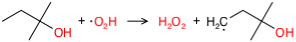

In [17]:


rSpecies1 = Molecule(SMILES="CCC(C)(C)O")
rSpecies2 = Molecule(SMILES="[O]O")
pSpecies2 = Molecule(SMILES="[CH2]CC(C)(C)O")
pSpecies1 = Molecule(SMILES="OO")


single_rotor_rxn = Reaction(reactants=[rSpecies1, rSpecies2], products=[pSpecies1, pSpecies2], reversible=True)
single_rotor_rxn

In [18]:


def all_in_one(oohReaction):
    rxnFamily = "H_Abstraction"
    rSpecies1, rSpecies2 = oohReaction.reactants
    pSpecies1, pSpecies2 = oohReaction.products

    rSpecies1.generateResonanceIsomers()
    rSpecies2.generateResonanceIsomers()
    pSpecies1.generateResonanceIsomers()
    pSpecies2.generateResonanceIsomers()

    testReaction = Reaction(reactants=[rSpecies1, rSpecies2], products=[pSpecies1, pSpecies2], reversible=True)
    reactionList = []
    tempList = rmgDatabase.kinetics.generateReactionsFromFamilies([rSpecies1, rSpecies2], [], only_families=[rxnFamily])
    for rxn0 in tempList:
        reactionList.append(rxn0)
    logging.info("generateReactionsFromFamilies successfuly performed")
    #print reactionList
    
    
    gotOne=False
    for reaction in reactionList:
        # Check if any of the RMG proposed reactions matches the reaction in the mechanism
        if testReaction.isIsomorphic(reaction):
            print "Found matching reaction"
            # Now add the labeled atoms to the Molecule, and check all labels were added
            atLblsR = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])
            atLblsP = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])

            for reactant in reaction.reactants:

                reactant.clearLabeledAtoms()
                for atom in reactant.atoms:
                    for atomLabel in reaction.labeledAtoms:
                        if atom==atomLabel[1]:
                            atom.label = atomLabel[0]
                            atLblsR[atomLabel[0]] = True
            for product in reaction.products:

                product.clearLabeledAtoms()
                for atom in product.atoms:
                    for atomLabel in reaction.labeledAtoms:
                        if atom==atomLabel[1]:
                            atom.label = atomLabel[0]
                            atLblsP[atomLabel[0]] = True
            if all( atLblsR.values() ) and all( atLblsP.values() ):
                gotOne=True
                break
    chemkinRxn = testReaction
    
    rxnFamily = "H_Abstraction"
    rxnFamilies = ['H_Abstraction']
    logging.info("chemkinRxn: {!r}".format(chemkinRxn))
    # Ensure all resonance isomers have been generated
    logging.info('Ensuring resonance isomers have been generated')
    for species in itertools.chain(chemkinRxn.reactants, chemkinRxn.products):
        print(type(species))
        species = species.generateResonanceIsomers()

    testReaction = Reaction(reactants=chemkinRxn.reactants, products=chemkinRxn.products, reversible=True)

    reactants = [species for species in chemkinRxn.reactants]
    # reactant_molecules is a list of lists of resonance isomers,
    # eg. a bimolecular reaction where the second reactant has 2 isomers is: [[r1],[r2i1,r2i2]]

    products = [species for species in chemkinRxn.products]
    # products is a list of molecule objects (only one resonance form of each product), eg [p1, p2]
    print reactants
    #print type(reactant_molecules[0])
    print products

    checkRxn = rmgDatabase.kinetics.generateReactionsFromFamilies(reactants, products, only_families=rxnFamilies)# reversible=True)
    if len(checkRxn) == 1:
        logging.info("Generated one reaction:")
        logging.info(checkRxn)
        reaction = checkRxn[0]
    else:  # didn't break from for loop
        for reaction in checkRxn:
            logging.info("Generated these reactions:")
            logging.info(reaction)
            reaction = checkRxn[0]
        raise Exception("Couldn't generate exactly one reaction matching {} in family {}".format(chemkinRxn, rxnFamilies))

    logging.info("The reaction of interest is as follows: ")
    logging.info(reaction)

    logging.info("asserting that the testReaction is Isomorphic")
    assert testReaction.isIsomorphic(reaction)
    logging.info("reaction: {!r}".format(reaction))

    atLblsR = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])
    atLblsP = dict([(lbl[0], False) for lbl in reaction.labeledAtoms])

    gotOne = False
    logging.info("Labeling reactant atoms")
    for reactant in reaction.reactants:
        reactant = reactant
        reactant.clearLabeledAtoms()
        for atom in reactant.atoms:
            for atomLabel in reaction.labeledAtoms:
                if atom == atomLabel[1]:
                    atom.label = atomLabel[0]
                    atLblsR[atomLabel[0]] = True

    logging.info("Labeling product atoms")
    for product in reaction.products:
        product = product
        product.clearLabeledAtoms()
        for atom in product.atoms:
            for atomLabel in reaction.labeledAtoms:
                if atom == atomLabel[1]:
                    atom.label = atomLabel[0]
                    atLblsP[atomLabel[0]] = True

    if all(atLblsR.values()) and all(atLblsP.values()):
        gotOne = True

    rxnFamily = reaction.family
    return reaction

single_rotor_rxn = all_in_one(single_rotor_rxn)
single_rotor_rxn = QMReaction(reaction=single_rotor_rxn, settings=settings, tsDatabase=tsDatabase)
single_rotor_rxn

<ipython-input-18-c97164135aa1>:18 all_in_one INFO generateReactionsFromFamilies successfuly performed
<ipython-input-18-c97164135aa1>:54 all_in_one INFO chemkinRxn: Reaction(reactants=[Molecule(SMILES="CCC(C)(C)O"), Molecule(SMILES="[O]O")], products=[Molecule(SMILES="OO"), Molecule(SMILES="[CH2]CC(C)(C)O")])
<ipython-input-18-c97164135aa1>:56 all_in_one INFO Ensuring resonance isomers have been generated
<ipython-input-18-c97164135aa1>:75 all_in_one INFO Generated one reaction:
<ipython-input-18-c97164135aa1>:76 all_in_one INFO [Reaction(reactants=[Molecule(SMILES="CCC(C)(C)O"), Molecule(SMILES="[O]O")], products=[Molecule(SMILES="OO"), Molecule(SMILES="[CH2]CC(C)(C)O")], degeneracy=3, pairs=[[Molecule(SMILES="CCC(C)(C)O"), Molecule(SMILES="[CH2]CC(C)(C)O")], [Molecule(SMILES="[O]O"), Molecule(SMILES="OO")]])]
<ipython-input-18-c97164135aa1>:85 all_in_one INFO The reaction of interest is as follows: 
<ipython-input-18-c97164135aa1>:86 all_in_one INFO <Molecule "CCC(C)(C)O"> + <Molecu

Found matching reaction
<type 'rmgpy.molecule.molecule.Molecule'>
<type 'rmgpy.molecule.molecule.Molecule'>
<type 'rmgpy.molecule.molecule.Molecule'>
<type 'rmgpy.molecule.molecule.Molecule'>
[Molecule(SMILES="CCC(C)(C)O"), Molecule(SMILES="[O]O")]
[Molecule(SMILES="OO"), Molecule(SMILES="[CH2]CC(C)(C)O")]


<rmgpy.qm.reaction.QMReaction instance at 0x11515aa28>

In [19]:

reactant, product = single_rotor_rxn.setupMolecules()
mol = reactant.toRDKitMol(removeHs=False)
AllChem.EmbedMolecule(mol)
view_mol(mol)

### Currently running into issues with the following chunk of code... Also, the issue that I had above isn't there any more... I'm confused... I look into this after lunch

In [20]:
labels, atomMatch = single_rotor_rxn.getLabels(reactant)

tsRDMol_1, bm, single_rotor_rxn.reactantGeom = single_rotor_rxn.generateBoundsMatrix(reactant)

bm = single_rotor_rxn.editMatrix(reactant, bm, labels)

tsRDMol_1 = single_rotor_rxn.reactantGeom.rd_embed(tsRDMol_1, 15, bm=bm, match=atomMatch)[0]

tsRDMol_1 = rdkit.Chem.rdchem.RWMol(tsRDMol_1)

view_mol(tsRDMol_1)



reaction.py:300 generateBoundsMatrix INFO Generating bounds matrix for CCC(C)(C)O.[O]O
reaction.py:338 bmPreEdit INFO Changing lower limit 2.9 to 2.393074
reaction.py:338 bmPreEdit INFO Changing lower limit 3.65 to 3.26214059416
reaction.py:338 bmPreEdit INFO Changing lower limit 2.520343 to 2.457475
molecule.py:140 rd_embed INFO RDKit failed to embed on attempt 1 of 15
molecule.py:140 rd_embed INFO RDKit failed to embed on attempt 2 of 15
molecule.py:140 rd_embed INFO RDKit failed to embed on attempt 3 of 15
molecule.py:140 rd_embed INFO RDKit failed to embed on attempt 4 of 15
molecule.py:140 rd_embed INFO RDKit failed to embed on attempt 5 of 15
molecule.py:140 rd_embed INFO RDKit failed to embed on attempt 6 of 15
molecule.py:140 rd_embed INFO RDKit failed to embed on attempt 7 of 15
molecule.py:140 rd_embed INFO RDKit failed to embed on attempt 8 of 15
molecule.py:140 rd_embed INFO RDKit failed to embed on attempt 9 of 15
molecule.py:140 rd_embed INFO RDKit failed to embed on atte

ArgumentError: Python argument types in
    RWMol.__init__(RWMol, NoneType)
did not match C++ signature:
    __init__(_object*, RDKit::ROMol, bool, int)
    __init__(_object*, RDKit::ROMol, bool)
    __init__(_object*, RDKit::ROMol)

In [21]:
def calc_energy_UFF(mol):
    """
    A function designed to calculate the energy of a molecule or TS
    
    Input: rdkit molecule object
    
    Output: energy of the geometry calculated using rdkit's forcefield method
    """
    """try:
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(mol)
    except:
    
        # Picking an arbitrarly large molecule to create a dummy mol properties forcefield object
        test_mol = Chem.AddHs(Chem.MolFromSmiles(
            "COC(=O)Cc1ccccc1CC2CC(O)C(C(=C)CC#CCC=O)C2OO"
        ))
        
        molprop = rdkit.Chem.ChemicalForceFields.MMFFGetMoleculeProperties(test_mol)"""
    ff = rdkit.Chem.ChemicalForceFields.UFFGetMoleculeForceField(mol)
    return ff.CalcEnergy()

In [25]:
calc_energy_UFF(tsRDMol_store)

33942.809312846766

In [24]:
view_mol(tsRDMol_store)